In [1]:
import numpy as np
import os
import pandas as pd
from pygam import LinearGAM, s, f, te
from sklearn.preprocessing import LabelEncoder

data=np.load('/scratch/fgomezacebo/Aggregated_dataset_converted.npy', allow_pickle = True)

In [3]:
df = pd.DataFrame(data)

# Identify rows with NaNs in %changeHR
nan_rows = df[df['%changeHR'].isna()]

# Replace NaNs based on matching Session and Mask
for index, row in nan_rows.iterrows():
    session = row['Session']
    mask = row['Mask']

    # Find a row with the same Session and Mask and a non-NaN %changeHR
    reference_rows = df[(df['Session'] == session) & (df['Mask'] == mask) & (df['%changeHR'].notna())]

    if not reference_rows.empty:
        # Get the first row with the same Session and Mask and a non-NaN %changeHR
        reference_row = reference_rows.iloc[0]

        # Replace the NaN in this row with the %changeHR value from the reference row
        df.loc[index, '%changeHR'] = reference_row['%changeHR']

# Print the DataFrame after replacing NaNs
print("DataFrame with NaNs in %changeHR replaced:")
print(df)

DataFrame with NaNs in %changeHR replaced:
     Session          Mask SubjectID  \
0       High  ACC_mask.nii        33   
1    Placebo  ACC_mask.nii        33   
2        Low  ACC_mask.nii        36   
3    Placebo  ACC_mask.nii         6   
4       High  ACC_mask.nii         3   
..       ...           ...       ...   
405     High  PCC_mask.nii        23   
406  Placebo  PCC_mask.nii        35   
407     High  PCC_mask.nii        25   
408     High  PCC_mask.nii        14   
409  Placebo  PCC_mask.nii         8   

                                            TimeCourse  \
0    [-1.9683935098297107, -0.8794252679081556, 0.7...   
1    [0.013833803606089158, 0.35618685424523355, -0...   
2    [0.03729551926550522, 0.5832213853278596, 0.16...   
3    [0.6021688128812214, 0.4645021239350509, -0.14...   
4    [0.8153549897052282, 0.552580064434198, 0.4153...   
..                                                 ...   
405  [0.07225854657220417, -0.421061973923787, -0.7...   
406  [0.2942

In [3]:
exploded_df = df.explode('TimeCourse', ignore_index=True)
exploded_df['%changeHR'] = df['%changeHR'].explode(ignore_index=True)

# Create a 'timeseries' column that goes from 0 to 431 and resets for every 432 rows
exploded_df['timeseries'] = np.arange(len(exploded_df)) % 432  # Using modulo to create the pattern

print("Exploded DataFrame with timeseries:")
print(exploded_df)

Exploded DataFrame with timeseries:
        Session          Mask SubjectID TimeCourse  %changeHR  timeseries
0          High  ACC_mask.nii        33   -1.96839   -60.7681           0
1          High  ACC_mask.nii        33  -0.879425    28.1558           1
2          High  ACC_mask.nii        33   0.728459    9.01463           2
3          High  ACC_mask.nii        33   0.199301   -32.3424           3
4          High  ACC_mask.nii        33   0.118243   -48.4637           4
...         ...           ...       ...        ...        ...         ...
177115  Placebo  PCC_mask.nii         8   -0.17771    16.0547         427
177116  Placebo  PCC_mask.nii         8   0.107698   0.943059         428
177117  Placebo  PCC_mask.nii         8  -0.349475     29.244         429
177118  Placebo  PCC_mask.nii         8   0.454371 -0.0768588         430
177119  Placebo  PCC_mask.nii         8   0.319332   -15.5423         431

[177120 rows x 6 columns]


In [5]:
categorical_features = ['Session', 'Mask', 'SubjectID']
label_encoders = {}

# Encoding each categorical feature with a separate LabelEncoder and store the encoders
for feature in categorical_features:
    le = LabelEncoder()
    exploded_df[feature] = le.fit_transform(exploded_df[feature])
    label_encoders[feature] = le

# Define target and features
y_target = exploded_df['TimeCourse']  # Target variable
X_features = exploded_df.drop(columns=['TimeCourse'])  # Features excluding the target

# Setup GAM with smooth and factor terms
terms = (s(X_features.columns.get_loc('timeseries'), n_splines=25) + 
         s(X_features.columns.get_loc('%changeHR'), n_splines=5) +
         f(X_features.columns.get_loc('Session')) + 
         f(X_features.columns.get_loc('Mask')) + 
         f(X_features.columns.get_loc('SubjectID'))+
          te(X_features.columns.get_loc('timeseries'), X_features.columns.get_loc('Session'))+
            te(X_features.columns.get_loc('timeseries'), X_features.columns.get_loc('Mask')))

# Initialize the GAM without fitting
gam = LinearGAM(terms)

# Define the grid of lambdas to search over: logarithmic scale is common
lams = np.logspace(-3, 3, 11)

# Perform grid search over lambda values, optimizing GCV
gam.gridsearch(X_features.values, y_target.values, lam=lams)

# After optimization
print("GAM optimized successfully with GCV:", gam.statistics_['GCV'])


100% (11 of 11) |########################| Elapsed Time: 0:01:47 Time:  0:01:47


GAM optimized successfully with GCV: 0.5383336944178978


In [19]:
print(gam.terms)

s(4) + s(3) + f(0) + f(1) + f(2) + te(4, 0) + te(4, 1) + intercept


In [16]:
# Calculate predictions and residuals
predicted = gam.predict(X_features.values)
residuals = y_target.values - predicted


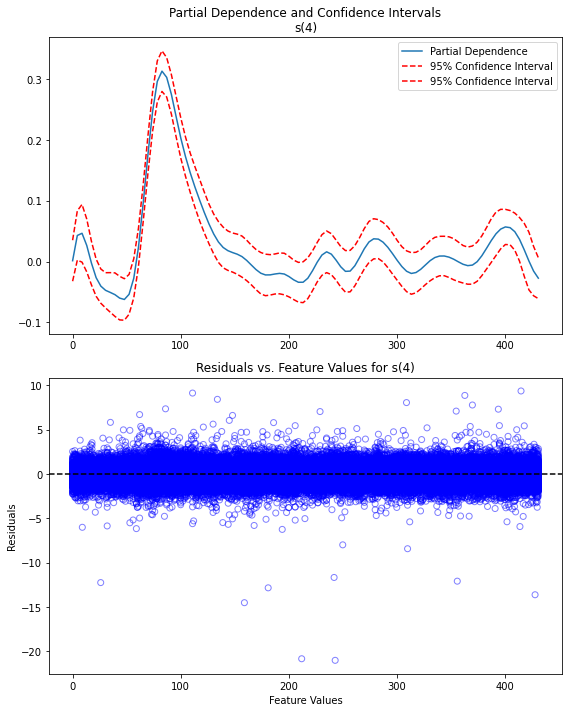

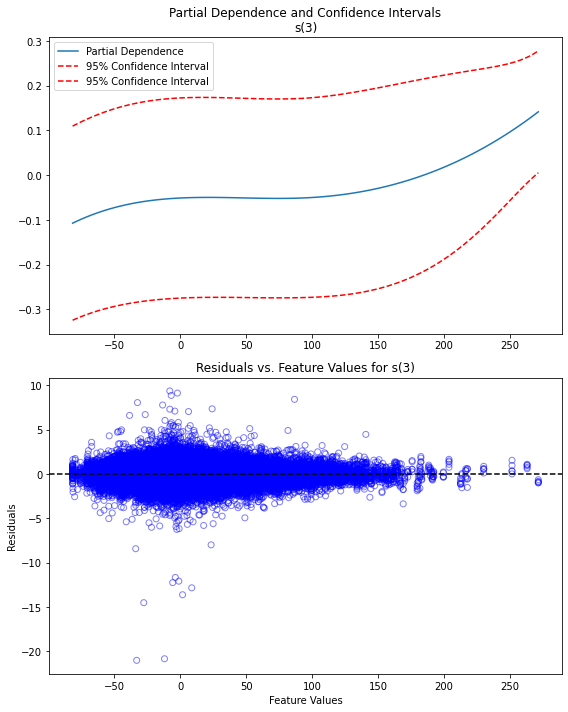

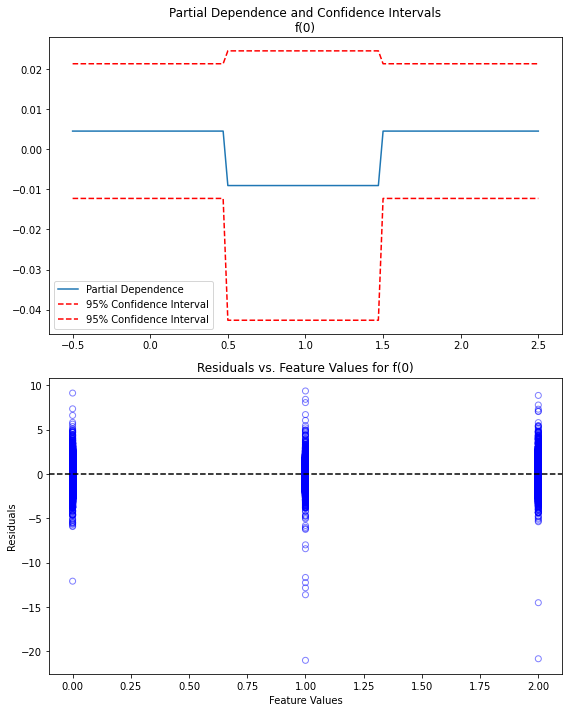

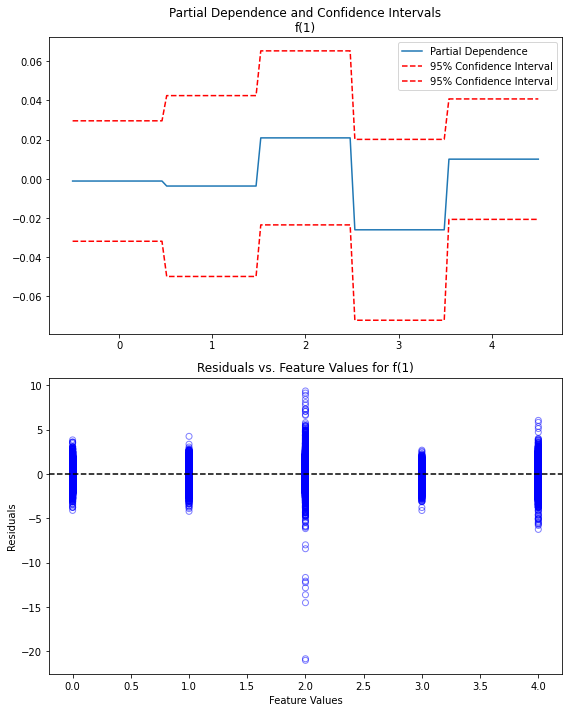

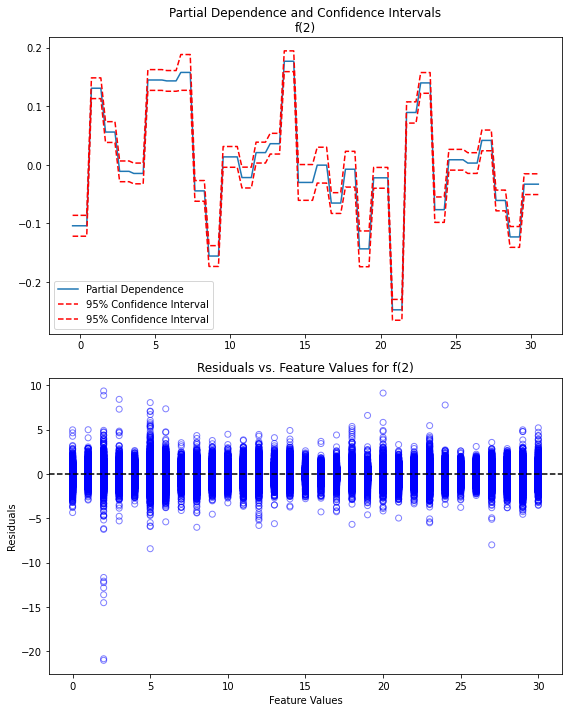

ValueError: x and y must be the same size

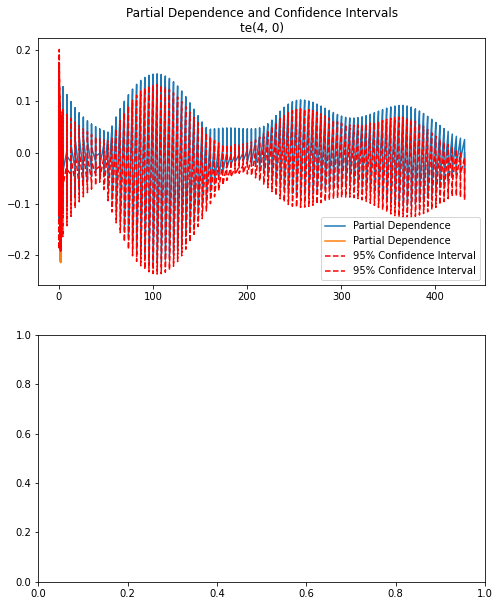

In [18]:
import matplotlib.pyplot as plt

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue  # Skip the intercept term

    # Generate a grid over which to calculate partial dependence
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Setup for two subplots: one for PDEP and one for residuals
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Plot partial dependence and confidence intervals
    axs[0].plot(XX[:, term.feature], pdep, label='Partial Dependence')
    axs[0].plot(XX[:, term.feature], confi, c='r', ls='--', label='95% Confidence Interval')
    axs[0].set_title('Partial Dependence and Confidence Intervals\n' + repr(term))
    axs[0].legend()

    # Calculate and plot residuals against the feature values for this term
    feature_values = X_features.values[:, term.feature]
    axs[1].scatter(feature_values, residuals, facecolors='none', edgecolors='b', alpha=0.5)
    axs[1].axhline(y=0, color='black', linestyle='--')
    axs[1].set_title('Residuals vs. Feature Values for ' + repr(term))
    axs[1].set_xlabel('Feature Values')
    axs[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, f, te
from tqdm import tqdm  # Import tqdm for the progress bar

# Assuming X_features is a DataFrame and y_target is a Series or a DataFrame column correctly aligned with X_features

# Correct way to create a DataFrame that includes both features and the target
data = X_features.copy()
data['y_target'] = y_target  # Make sure 'y_target' is named correctly

# Define the bootstrap function
def bootstrap_gam_difference(data, predictors_columns, response_column, n_bootstraps=10):
    differences = []
    np.random.seed(42)  # For reproducibility

    # Add tqdm progress bar around the range function
    for i in tqdm(range(n_bootstraps), desc='Bootstrapping progress'):
        # Resample the data with replacement
        sample_indices = np.random.choice(data.index, size=len(data), replace=True)
        sample = data.iloc[sample_indices]

        # Fit the model to the bootstrap sample
        gam_sample = LinearGAM(
            s(predictors_columns.get_loc('timeseries'), n_splines=5) + 
            s(predictors_columns.get_loc('%changeHR'), n_splines=15) +
            f(predictors_columns.get_loc('Session')) +
            f(predictors_columns.get_loc('Mask')) +
            f(predictors_columns.get_loc('SubjectID')) +
            te(predictors_columns.get_loc('timeseries'), predictors_columns.get_loc('Session')) +
            te(predictors_columns.get_loc('timeseries'), predictors_columns.get_loc('Mask'))
        ).fit(sample[predictors_columns], sample[response_column])

        # Generate predictions for specific levels of 'Session'
        # Hypothetically, let's assume Session levels are 0 and 1
        pred1 = gam_sample.predict(sample[sample['Session'] == 0][predictors_columns])
        pred2 = gam_sample.predict(sample[sample['Session'] == 1][predictors_columns])

        # Calculate the difference in predictions
        diff = np.mean(pred1) - np.mean(pred2)  # Average difference for this bootstrap
        differences.append(diff)

    return differences

# Use the function
predictors_columns = data.columns.drop('y_target')  # Exclude the target column from predictors
bootstrap_differences = bootstrap_gam_difference(data, predictors_columns, 'y_target')
lower_bound = np.percentile(bootstrap_differences, 2.5)
upper_bound = np.percentile(bootstrap_differences, 97.5)

print(f"95% Confidence Interval for the difference between Session levels 0 and 1: ({lower_bound}, {upper_bound})")


Bootstrapping progress: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]

95% Confidence Interval for the difference between Session levels 0 and 1: (0.04997543314059627, 0.06377203347040922)


In [23]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, f, te
from scipy.stats import ttest_ind

# Assuming X_features is a DataFrame containing all predictors and y_target is correctly aligned with X_features
data = X_features.copy()
data['%changeHR'] = data['%changeHR'].astype(int)  # Ensure %changeHR is an integer
data['y_target'] = y_target.astype(int)  # Ensure y_target is an integer

def compare_conditions(data, gam, condition, value1, value2, n_samples=10):
    np.random.seed(42)  # For reproducibility
    predictions1 = []
    predictions2 = []

    for _ in range(n_samples):
        # Resample the data with replacement
        sampled_data = data.sample(frac=1, replace=True)
        
        # Create subsets for the two conditions
        subset1 = sampled_data[sampled_data[condition] == value1]
        subset2 = sampled_data[sampled_data[condition] == value2]
        
        # Make predictions
        if not subset1.empty:
            pred1 = gam.predict(subset1)
            predictions1.extend(pred1)
        if not subset2.empty:
            pred2 = gam.predict(subset2)
            predictions2.extend(pred2)

    # Conduct a t-test on the pooled predictions from both conditions
    stat, p_value = ttest_ind(predictions1, predictions2, equal_var=False)  # Welch's t-test for unequal variances

    return stat, p_value

# Define and fit your GAM model here as per your GAM configuration
gam = LinearGAM(
    s(data.columns.get_loc('timeseries'), n_splines=5) + 
    s(data.columns.get_loc('%changeHR'), n_splines=15) +
    f(data.columns.get_loc('Session')) +
    f(data.columns.get_loc('Mask')) +
    f(data.columns.get_loc('SubjectID')) +
    te(data.columns.get_loc('timeseries'), data.columns.get_loc('Session')) +
    te(data.columns.get_loc('timeseries'), data.columns.get_loc('Mask'))
).fit(data.drop('y_target', axis=1), data['y_target'])

# Use the function
stat, p_value = compare_conditions(X_features, gam, 'Session', 0, 1)  # Adjust 0 and 1 according to the encoded session values
print(f"T-statistic: {stat}, P-value: {p_value}")



T-statistic: 233.28595022315977, P-value: 0.0


In [7]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    114.7512
Link Function:                     IdentityLink Log Likelihood:                               -217462.4295
Number of Samples:                       177120 AIC:                                           435156.3613
                                                AICc:                                           435156.514
                                                GCV:                                                0.5383
                                                Scale:                                              0.5377
                                                Pseudo R-Squared:                                   0.0422
Feature Function                  Lam

/home/fgomezacebo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [39]:
from pygam import LinearGAM, s, f, te
from scipy.stats import chi2

# Assuming X_features, y_target are already defined

gam.fit(X_features, y_target)

# Reduced model without interaction
reduced_model_mask = LinearGAM(s(X_features.columns.get_loc('timeseries'), n_splines=25) + 
         s(X_features.columns.get_loc('%changeHR'), n_splines=5) +
         f(X_features.columns.get_loc('Session')) + 
         f(X_features.columns.get_loc('Mask')) + 
         f(X_features.columns.get_loc('SubjectID'))+
          te(X_features.columns.get_loc('timeseries'), X_features.columns.get_loc('Session')))
reduced_model_mask.fit(X_features, y_target)

lr = 2 * (gam.loglikelihood(X_features, y_target) - reduced_model_mask.loglikelihood(X_features, y_target))
p_value = chi2.sf(lr, df=gam.statistics_['edof'] - reduced_model_mask.statistics_['edof'])

print(f"Likelihood Ratio: {lr}, p-value: {p_value}")


Likelihood Ratio: 104.40441633743467, p-value: 5.7734803073408945e-09


In [41]:
from pygam import LinearGAM, s, f, te
from scipy.stats import chi2

# Assuming X_features, y_target are already defined

gam.fit(X_features, y_target)

# Reduced model without interaction
reduced_model_ses = LinearGAM(s(X_features.columns.get_loc('timeseries'), n_splines=25) + 
         s(X_features.columns.get_loc('%changeHR'), n_splines=5) +
         f(X_features.columns.get_loc('Session')) + 
         f(X_features.columns.get_loc('Mask')) + 
         f(X_features.columns.get_loc('SubjectID'))+
          te(X_features.columns.get_loc('timeseries'), X_features.columns.get_loc('Mask')))
reduced_model_ses.fit(X_features, y_target)

lr = 2 * (gam.loglikelihood(X_features, y_target) - reduced_model_ses.loglikelihood(X_features, y_target))
p_value = chi2.sf(lr, df=gam.statistics_['edof'] - reduced_model_ses.statistics_['edof'])

print(f"Likelihood Ratio: {lr}, p-value: {p_value}")

Likelihood Ratio: 135.57041165762348, p-value: 2.388805217920408e-19


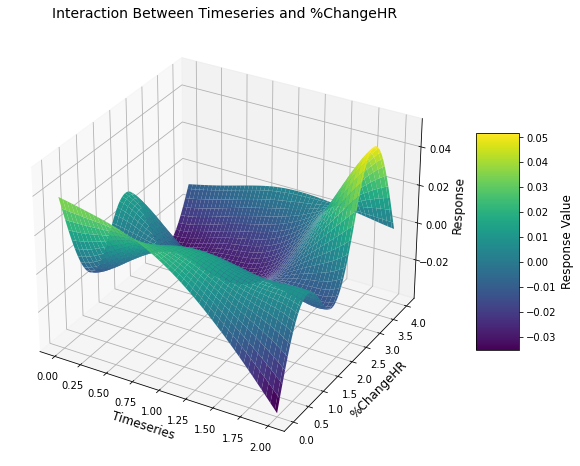

In [9]:
# Interaction between 'timeseries' and '%changeHR'
terms = (s(0, n_splines=10) + s(1, n_splines=10) + te(0, 1, n_splines=10))

# Assuming X_features and y_target are predefined and appropriate for the model
gam = LinearGAM(terms).fit(X_features, y_target)

# Generate grid for partial dependency plots
XX = gam.generate_X_grid(term=2, meshgrid=True)  # Assuming term=2 is our interaction term
Z = gam.partial_dependence(term=2, X=XX, meshgrid=True)

# Plotting the interaction
fig = plt.figure(figsize=(12, 8))  # Adjusting figure size here
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax.set_xlabel('Timeseries', fontsize=12)  # Increasing font size for better visibility
ax.set_ylabel('%ChangeHR', fontsize=12)
ax.set_zlabel('Response', fontsize=12)
plt.title('Interaction Between Timeseries and %ChangeHR', fontsize=14)

# Adding a color bar to the plot to indicate values
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Response Value', fontsize=12)

plt.show()


100% (11 of 11) |########################| Elapsed Time: 0:01:05 Time:  0:01:05


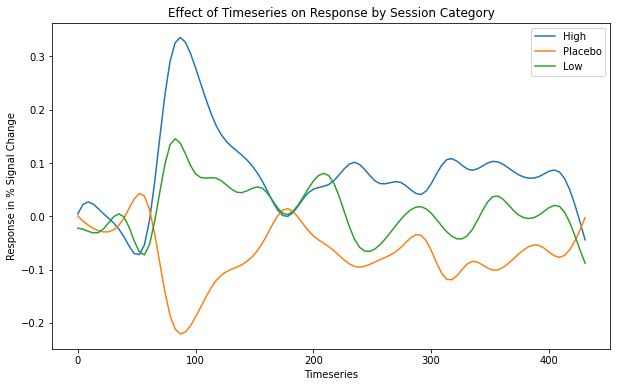

Effect values have been stored in 'effect_values.csv'


In [7]:
# Prepare the 2D plot
plt.figure(figsize=(10, 6))

# Find the category closest to 1 in the generated session values
session_values = np.unique(XX[1])  # Extract unique session values from the generated grid
closest_session = session_values[np.argmin(np.abs(session_values - 1))]

# Define specific session categories to plot, including the closest to 1
specific_sessions = [0, 2, closest_session]
labels = ['High', 'Placebo', 'Low']

# Initialize a list to store the data
data = []

# Plot each specified session's timeseries response
for session, label in zip(specific_sessions, labels):
    mask = XX[1] == session
    timeseries = XX[0][mask]
    response = Z[mask]
    
    # Plotting
    plt.plot(timeseries, response, label=label)
    
    # Store the data in the list
    for t, r in zip(timeseries, response):
        data.append({'Session': label, 'Timeseries': t, 'Response': r})

plt.xlabel('Timeseries')
plt.ylabel('Response in % Signal Change')
plt.title('Effect of Timeseries on Response by Session Category')
plt.legend()
plt.show()

# Convert the list to a DataFrame
effect_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
#effect_df.to_csv('effect_values.csv', index=False)

print("Effect values have been stored in 'effect_values.csv'")


In [11]:
print(effect_df)
# Save the DataFrame to a CSV file
effect_df.to_csv('/scratch/fgomezacebo/Condition_GAM_effect_values.csv', index=False)

    Session  Timeseries  Response
0      High    0.000000  0.004403
1      High    4.353535  0.022177
2      High    8.707071  0.026972
3      High   13.060606  0.022947
4      High   17.414141  0.014264
..      ...         ...       ...
295     Low  413.585859  0.007839
296     Low  417.939394 -0.011505
297     Low  422.292929 -0.036169
298     Low  426.646465 -0.062739
299     Low  431.000000 -0.087800

[300 rows x 3 columns]


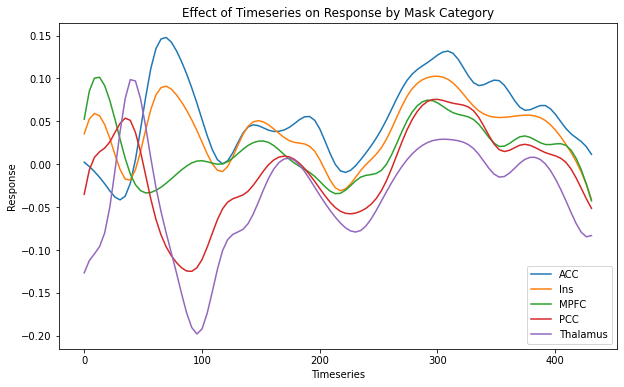

In [16]:
# Prepare the 2D plot
plt.figure(figsize=(10, 6))

# Define specific Mask categories to plot
desired_masks = [0, 1, 2, 3, 4]
mask_names = ['ACC', 'Ins', 'MPFC', 'PCC',
 'Thalamus']  # Specify desired names here

# Find the closest actual values to the desired mask categories
actual_mask_values = np.unique(XX[1])  # Extract unique mask values from the generated grid
closest_values = {desired: actual_mask_values[np.argmin(np.abs(actual_mask_values - desired))] for desired in desired_masks}

# Plot each closest Mask category's timeseries response
for mask, mask_name in zip(desired_masks, mask_names):
    closest_mask = closest_values[mask]
    mask_data = XX[1] == closest_mask
    plt.plot(XX[0][mask_data], Z[mask_data], label=f'{mask_name}')

plt.xlabel('Timeseries')
plt.ylabel('Response')
plt.title('Effect of Timeseries on Response by Mask Category')
plt.legend()
plt.show()
